# Load data

In [12]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import random
%matplotlib inline  

In [15]:
def load_images(path):
    files = [file for folder in os.walk(path) for file in glob.glob(os.path.join(folder[0], '*.png'))]
    random.shuffle(files)
    return files

cars = load_images("data/vehicles/")
notcars = load_images("data/non-vehicles/")

total  cars :  8792
total  notcars :  8968


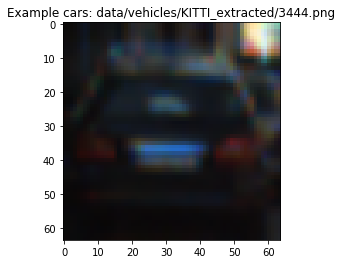

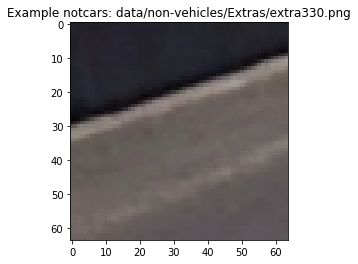

In [16]:
def describe(cars, title):
    print("total ", title, ": ", len(cars))
    car=cars[0]
    car_img = mpimg.imread(car)
    plt.figure()
    plt.title("Example {}: {}".format(title, car))
    plt.imshow(car_img)

describe(cars,"cars")
describe(notcars,"notcars")
    
    

# Extract features

In [17]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

/home/chomnoue/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


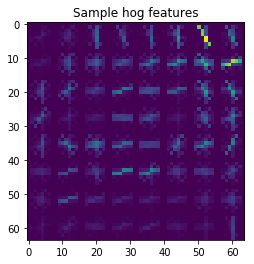

In [18]:
sample_hog_image= get_hog_features(mpimg.imread(cars[0])[:,:,0], 9, 8, 2,vis=True, feature_vec=False)[1]
plt.figure()
plt.title("Sample hog features")
plt.imshow(sample_hog_image)

In [19]:
def build_model(colorspace, orient, pix_per_cell, cell_per_block, hog_channel, cars_sampe, notcars_sample):
    t=time.time()
    car_features = extract_features(cars_sampe, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    notcar_features = extract_features(notcars_sample, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    print('Using: ',colorspace," color space, ",orient,' orientations, ',pix_per_cell,
                            ' pixels per cell, ', cell_per_block,' cells per block and ',hog_channel, ' hog channel')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    accuracy = round(svc.score(X_test, y_test), 4)
    print('Test Accuracy of SVC = ', accuracy)
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    return svc, accuracy

In [23]:
# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars_sampe = cars[0:sample_size]
notcars_sample = notcars[0:sample_size]
max_accuracy = 0
max_parameters = ()
color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
orients = [6,9,12]
pix_per_cells = [4, 8,16]
cell_per_blocks = [2,4]
hog_channels = [0, 1, 2, "ALL"]
total_steps = len(color_spaces)*len(orients)*len(pix_per_cells)*len(cell_per_blocks)*len(hog_channels)
step = 0
for colorspace in color_spaces:
    for orient in  orients:
        for pix_per_cell in pix_per_cells:
            for cell_per_block in cell_per_blocks:
                for hog_channel in hog_channels:    
                    step=step+1
                    parameters = (colorspace, orient, pix_per_cell, cell_per_block, hog_channel)
                    print("")
                    print("**************************************************************")
                    print("running step {}/{} ({}%)".format(step,total_steps, 100.0*step/total_steps))
                    print("parameters: ",parameters)
                    try:
                        svc, accuracy = build_model(colorspace, orient, pix_per_cell, cell_per_block, hog_channel, cars_sampe, notcars_sample)
                    except Exception as err:
                        print(err)
                        continue
                    if(accuracy > max_accuracy):
                        print("got max accuracy!")
                        max_accuracy = accuracy
                        max_parameters = parameters


**************************************************************
running step 1/432 (0.23148148148148148%)
parameters:  ('RGB', 6, 4, 2, 0)


/home/chomnoue/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


2.96 Seconds to extract HOG features...
Using:  RGB  color space,  6  orientations,  4  pixels per cell,  2  cells per block and  0  hog channel
Feature vector length: 5400
0.22 Seconds to train SVC...
Test Accuracy of SVC =  0.93
My SVC predicts:  [ 1.  0.  1.  1.  0.  0.  1.  0.  1.  0.]
For these 10 labels:  [ 1.  0.  1.  1.  0.  0.  1.  0.  1.  0.]
0.00158 Seconds to predict 10 labels with SVC
got max accuracy!

**************************************************************
running step 2/432 (0.46296296296296297%)
parameters:  ('RGB', 6, 4, 2, 1)
3.33 Seconds to extract HOG features...
Using:  RGB  color space,  6  orientations,  4  pixels per cell,  2  cells per block and  1  hog channel
Feature vector length: 5400
0.19 Seconds to train SVC...
Test Accuracy of SVC =  0.935
My SVC predicts:  [ 0.  0.  1.  0.  1.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  0.  1.  0.  0.  1.]
0.00161 Seconds to predict 10 labels with SVC
got max accuracy!

*********************

0.54 Seconds to train SVC...
Test Accuracy of SVC =  0.89
My SVC predicts:  [ 1.  1.  0.  1.  0.  1.  0.  1.  0.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  1.  0.  1.  0.  1.]
0.00167 Seconds to predict 10 labels with SVC

**************************************************************
running step 17/432 (3.935185185185185%)
parameters:  ('RGB', 6, 16, 2, 0)
1.06 Seconds to extract HOG features...
Using:  RGB  color space,  6  orientations,  16  pixels per cell,  2  cells per block and  0  hog channel
Feature vector length: 216
0.08 Seconds to train SVC...
Test Accuracy of SVC =  0.865
My SVC predicts:  [ 1.  1.  1.  0.  0.  1.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  1.  0.  0.  1.  1.  1.  0.  0.  0.]
0.00158 Seconds to predict 10 labels with SVC

**************************************************************
running step 18/432 (4.166666666666667%)
parameters:  ('RGB', 6, 16, 2, 1)
1.04 Seconds to extract HOG features...
Using:  RGB  color space,  6  orientations,  16  pix

6.99 Seconds to extract HOG features...
Using:  RGB  color space,  9  orientations,  4  pixels per cell,  4  cells per block and  ALL  hog channel
Feature vector length: 73008
2.41 Seconds to train SVC...
Test Accuracy of SVC =  0.975
My SVC predicts:  [ 0.  1.  0.  0.  0.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  0.  1.  1.  1.  0.  0.]
0.00269 Seconds to predict 10 labels with SVC
got max accuracy!

**************************************************************
running step 33/432 (7.638888888888889%)
parameters:  ('RGB', 9, 8, 2, 0)
1.45 Seconds to extract HOG features...
Using:  RGB  color space,  9  orientations,  8  pixels per cell,  2  cells per block and  0  hog channel
Feature vector length: 1764
0.07 Seconds to train SVC...
Test Accuracy of SVC =  0.895
My SVC predicts:  [ 1.  0.  1.  1.  0.  0.  1.  1.  0.  0.]
For these 10 labels:  [ 1.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
0.00166 Seconds to predict 10 labels with SVC

************************************

2.64 Seconds to extract HOG features...
Using:  RGB  color space,  9  orientations,  16  pixels per cell,  4  cells per block and  ALL  hog channel
Feature vector length: 432
0.11 Seconds to train SVC...
Test Accuracy of SVC =  0.92
My SVC predicts:  [ 1.  1.  1.  1.  0.  0.  0.  1.  1.  0.]
For these 10 labels:  [ 1.  1.  1.  0.  0.  0.  0.  1.  0.  1.]
0.00155 Seconds to predict 10 labels with SVC

**************************************************************
running step 49/432 (11.342592592592593%)
parameters:  ('RGB', 12, 4, 2, 0)
3.1 Seconds to extract HOG features...
Using:  RGB  color space,  12  orientations,  4  pixels per cell,  2  cells per block and  0  hog channel
Feature vector length: 10800
0.34 Seconds to train SVC...
Test Accuracy of SVC =  0.915
My SVC predicts:  [ 1.  0.  0.  0.  1.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.]
0.00165 Seconds to predict 10 labels with SVC

*****************************************************

0.2 Seconds to train SVC...
Test Accuracy of SVC =  0.88
My SVC predicts:  [ 1.  0.  0.  1.  0.  1.  0.  0.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  1.  1.  1.  0.  0.  1.  0.]
0.00161 Seconds to predict 10 labels with SVC

**************************************************************
running step 64/432 (14.814814814814815%)
parameters:  ('RGB', 12, 8, 4, 'ALL')
3.18 Seconds to extract HOG features...
Using:  RGB  color space,  12  orientations,  8  pixels per cell,  4  cells per block and  ALL  hog channel
Feature vector length: 14400
0.58 Seconds to train SVC...
Test Accuracy of SVC =  0.935
My SVC predicts:  [ 1.  1.  1.  0.  0.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  1.  0.  0.  1.  0.  0.  0.  0.]
0.00171 Seconds to predict 10 labels with SVC

**************************************************************
running step 65/432 (15.046296296296296%)
parameters:  ('RGB', 12, 16, 2, 0)
1.21 Seconds to extract HOG features...
Using:  RGB  color space,  12  orientation

2.51 Seconds to extract HOG features...
Using:  HSV  color space,  6  orientations,  4  pixels per cell,  4  cells per block and  2  hog channel
Feature vector length: 16224
0.59 Seconds to train SVC...
Test Accuracy of SVC =  0.915
My SVC predicts:  [ 1.  1.  0.  0.  1.  0.  1.  0.  1.  0.]
For these 10 labels:  [ 1.  1.  1.  0.  1.  1.  1.  0.  1.  1.]
0.00182 Seconds to predict 10 labels with SVC

**************************************************************
running step 80/432 (18.51851851851852%)
parameters:  ('HSV', 6, 4, 4, 'ALL')
6.69 Seconds to extract HOG features...
Using:  HSV  color space,  6  orientations,  4  pixels per cell,  4  cells per block and  ALL  hog channel
Feature vector length: 48672
1.35 Seconds to train SVC...
Test Accuracy of SVC =  0.965
My SVC predicts:  [ 1.  1.  1.  0.  0.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  1.  0.  0.  1.  0.  0.  0.  0.]
0.00234 Seconds to predict 10 labels with SVC

*************************************************

1.0 Seconds to extract HOG features...
Using:  HSV  color space,  6  orientations,  16  pixels per cell,  4  cells per block and  2  hog channel
Feature vector length: 96
0.05 Seconds to train SVC...
Test Accuracy of SVC =  0.86
My SVC predicts:  [ 0.  0.  1.  1.  1.  0.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  1.  0.  0.  1.  0.]
0.00164 Seconds to predict 10 labels with SVC

**************************************************************
running step 96/432 (22.22222222222222%)
parameters:  ('HSV', 6, 16, 4, 'ALL')
2.12 Seconds to extract HOG features...
Using:  HSV  color space,  6  orientations,  16  pixels per cell,  4  cells per block and  ALL  hog channel
Feature vector length: 288
0.03 Seconds to train SVC...
Test Accuracy of SVC =  0.94
My SVC predicts:  [ 1.  1.  0.  0.  0.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  0.  1.  1.  1.  0.  0.  0.]
0.0016 Seconds to predict 10 labels with SVC

*******************************************************

0.31 Seconds to train SVC...
Test Accuracy of SVC =  0.84
My SVC predicts:  [ 1.  0.  0.  0.  1.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  0.  1.  0.  0.  1.]
0.00159 Seconds to predict 10 labels with SVC

**************************************************************
running step 111/432 (25.694444444444443%)
parameters:  ('HSV', 9, 8, 4, 2)
1.31 Seconds to extract HOG features...
Using:  HSV  color space,  9  orientations,  8  pixels per cell,  4  cells per block and  2  hog channel
Feature vector length: 3600
0.2 Seconds to train SVC...
Test Accuracy of SVC =  0.945
My SVC predicts:  [ 1.  0.  0.  0.  1.  1.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  1.  1.  1.  0.  0.  1.]
0.00171 Seconds to predict 10 labels with SVC

**************************************************************
running step 112/432 (25.925925925925927%)
parameters:  ('HSV', 9, 8, 4, 'ALL')
3.03 Seconds to extract HOG features...
Using:  HSV  color space,  9  orientations,  8 

0.93 Seconds to train SVC...
Test Accuracy of SVC =  0.91
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  1.  1.  1.  0.  0.  1.]
0.00202 Seconds to predict 10 labels with SVC

**************************************************************
running step 126/432 (29.166666666666668%)
parameters:  ('HSV', 12, 4, 4, 1)
2.77 Seconds to extract HOG features...
Using:  HSV  color space,  12  orientations,  4  pixels per cell,  4  cells per block and  1  hog channel
Feature vector length: 32448
1.16 Seconds to train SVC...
Test Accuracy of SVC =  0.87
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  1.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  0.  1.  0.  1.  0.  1.  0.]
0.00204 Seconds to predict 10 labels with SVC

**************************************************************
running step 127/432 (29.39814814814815%)
parameters:  ('HSV', 12, 4, 4, 2)
2.95 Seconds to extract HOG features...
Using:  HSV  color space,  12  orientations,  4 

1.12 Seconds to extract HOG features...
Using:  HSV  color space,  12  orientations,  16  pixels per cell,  4  cells per block and  0  hog channel
Feature vector length: 192
0.07 Seconds to train SVC...
Test Accuracy of SVC =  0.905
My SVC predicts:  [ 1.  1.  0.  1.  0.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
0.00155 Seconds to predict 10 labels with SVC

**************************************************************
running step 142/432 (32.870370370370374%)
parameters:  ('HSV', 12, 16, 4, 1)
1.12 Seconds to extract HOG features...
Using:  HSV  color space,  12  orientations,  16  pixels per cell,  4  cells per block and  1  hog channel
Feature vector length: 192
0.09 Seconds to train SVC...
Test Accuracy of SVC =  0.77
My SVC predicts:  [ 1.  0.  0.  1.  0.  1.  0.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  0.  1.  1.  1.  0.  0.  0.  0.]
0.00154 Seconds to predict 10 labels with SVC

****************************************************

/home/chomnoue/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:144: RuntimeWarning: invalid value encountered in sqrt
  image = np.sqrt(image)


3.23 Seconds to extract HOG features...
Input contains NaN, infinity or a value too large for dtype('float64').

**************************************************************
running step 147/432 (34.02777777777778%)
parameters:  ('LUV', 6, 4, 2, 2)
3.16 Seconds to extract HOG features...
Input contains NaN, infinity or a value too large for dtype('float64').

**************************************************************
running step 148/432 (34.25925925925926%)
parameters:  ('LUV', 6, 4, 2, 'ALL')
8.35 Seconds to extract HOG features...
Input contains NaN, infinity or a value too large for dtype('float64').

**************************************************************
running step 149/432 (34.49074074074074%)
parameters:  ('LUV', 6, 4, 4, 0)
2.58 Seconds to extract HOG features...
Using:  LUV  color space,  6  orientations,  4  pixels per cell,  4  cells per block and  0  hog channel
Feature vector length: 16224
0.63 Seconds to train SVC...
Test Accuracy of SVC =  0.925
My SVC pre

8.96 Seconds to extract HOG features...
Input contains NaN, infinity or a value too large for dtype('float64').

**************************************************************
running step 173/432 (40.0462962962963%)
parameters:  ('LUV', 9, 4, 4, 0)
2.8 Seconds to extract HOG features...
Using:  LUV  color space,  9  orientations,  4  pixels per cell,  4  cells per block and  0  hog channel
Feature vector length: 24336
0.99 Seconds to train SVC...
Test Accuracy of SVC =  0.92
My SVC predicts:  [ 0.  0.  1.  0.  1.  1.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  1.  0.  0.  1.  0.]
0.00187 Seconds to predict 10 labels with SVC

**************************************************************
running step 174/432 (40.27777777777778%)
parameters:  ('LUV', 9, 4, 4, 1)
3.08 Seconds to extract HOG features...
Input contains NaN, infinity or a value too large for dtype('float64').

**************************************************************
running step 175/432 (40.509259259

0.98 Seconds to train SVC...
Test Accuracy of SVC =  0.945
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  1.  1.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  0.  1.  1.  1.]
0.002 Seconds to predict 10 labels with SVC

**************************************************************
running step 198/432 (45.833333333333336%)
parameters:  ('LUV', 12, 4, 4, 1)
3.07 Seconds to extract HOG features...
Input contains NaN, infinity or a value too large for dtype('float64').

**************************************************************
running step 199/432 (46.06481481481482%)
parameters:  ('LUV', 12, 4, 4, 2)
3.01 Seconds to extract HOG features...
Input contains NaN, infinity or a value too large for dtype('float64').

**************************************************************
running step 200/432 (46.2962962962963%)
parameters:  ('LUV', 12, 4, 4, 'ALL')
7.87 Seconds to extract HOG features...
Input contains NaN, infinity or a value too large for dtype('float64').

************

2.51 Seconds to extract HOG features...
Using:  HLS  color space,  6  orientations,  4  pixels per cell,  4  cells per block and  0  hog channel
Feature vector length: 16224
0.57 Seconds to train SVC...
Test Accuracy of SVC =  0.89
My SVC predicts:  [ 0.  1.  0.  1.  1.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  1.  0.  1.  0.  1.]
0.00174 Seconds to predict 10 labels with SVC

**************************************************************
running step 222/432 (51.388888888888886%)
parameters:  ('HLS', 6, 4, 4, 1)
2.51 Seconds to extract HOG features...
Using:  HLS  color space,  6  orientations,  4  pixels per cell,  4  cells per block and  1  hog channel
Feature vector length: 16224
0.75 Seconds to train SVC...
Test Accuracy of SVC =  0.92
My SVC predicts:  [ 0.  1.  1.  0.  1.  1.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  0.  1.  1.  1.  0.]
0.00183 Seconds to predict 10 labels with SVC

*******************************************************

1.04 Seconds to extract HOG features...
Using:  HLS  color space,  6  orientations,  16  pixels per cell,  4  cells per block and  0  hog channel
Feature vector length: 96
0.07 Seconds to train SVC...
Test Accuracy of SVC =  0.89
My SVC predicts:  [ 0.  1.  0.  1.  1.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  1.  0.  1.  0.  1.  0.  0.  1.  0.]
0.00158 Seconds to predict 10 labels with SVC

**************************************************************
running step 238/432 (55.092592592592595%)
parameters:  ('HLS', 6, 16, 4, 1)
1.01 Seconds to extract HOG features...
Using:  HLS  color space,  6  orientations,  16  pixels per cell,  4  cells per block and  1  hog channel
Feature vector length: 96
0.05 Seconds to train SVC...
Test Accuracy of SVC =  0.87
My SVC predicts:  [ 1.  0.  0.  0.  1.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  1.  1.  1.  0.  0.]
0.00159 Seconds to predict 10 labels with SVC

**********************************************************

0.16 Seconds to train SVC...
Test Accuracy of SVC =  0.985
My SVC predicts:  [ 0.  0.  1.  0.  1.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  0.  0.  0.  1.  0.]
0.00161 Seconds to predict 10 labels with SVC

**************************************************************
running step 253/432 (58.56481481481482%)
parameters:  ('HLS', 9, 8, 4, 0)
1.33 Seconds to extract HOG features...
Using:  HLS  color space,  9  orientations,  8  pixels per cell,  4  cells per block and  0  hog channel
Feature vector length: 3600
0.23 Seconds to train SVC...
Test Accuracy of SVC =  0.865
My SVC predicts:  [ 1.  1.  1.  0.  0.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  0.  1.  1.  1.  0.  0.  0.]
0.00166 Seconds to predict 10 labels with SVC

**************************************************************
running step 254/432 (58.7962962962963%)
parameters:  ('HLS', 9, 8, 4, 1)
1.3 Seconds to extract HOG features...
Using:  HLS  color space,  9  orientations,  8  pixel

8.15 Seconds to extract HOG features...
Using:  HLS  color space,  12  orientations,  4  pixels per cell,  2  cells per block and  ALL  hog channel
Feature vector length: 32400
0.76 Seconds to train SVC...
Test Accuracy of SVC =  0.97
My SVC predicts:  [ 0.  1.  0.  0.  0.  0.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  0.  0.  0.  1.  1.  0.]
0.00199 Seconds to predict 10 labels with SVC

**************************************************************
running step 269/432 (62.26851851851852%)
parameters:  ('HLS', 12, 4, 4, 0)
2.91 Seconds to extract HOG features...
Using:  HLS  color space,  12  orientations,  4  pixels per cell,  4  cells per block and  0  hog channel
Feature vector length: 32448
0.94 Seconds to train SVC...
Test Accuracy of SVC =  0.9
My SVC predicts:  [ 1.  0.  0.  1.  0.  0.  0.  1.  1.  0.]
For these 10 labels:  [ 1.  0.  0.  1.  0.  0.  0.  1.  1.  0.]
0.002 Seconds to predict 10 labels with SVC

******************************************************

0.21 Seconds to train SVC...
Test Accuracy of SVC =  0.79
My SVC predicts:  [ 0.  0.  0.  0.  1.  1.  1.  1.  1.  1.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  1.  0.  1.  1.  1.]
0.00262 Seconds to predict 10 labels with SVC

**************************************************************
running step 284/432 (65.74074074074075%)
parameters:  ('HLS', 12, 16, 2, 'ALL')
2.64 Seconds to extract HOG features...
Using:  HLS  color space,  12  orientations,  16  pixels per cell,  2  cells per block and  ALL  hog channel
Feature vector length: 1296
0.05 Seconds to train SVC...
Test Accuracy of SVC =  0.97
My SVC predicts:  [ 0.  0.  0.  1.  1.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  1.  1.  0.  0.  0.  0.]
0.00151 Seconds to predict 10 labels with SVC

**************************************************************
running step 285/432 (65.97222222222223%)
parameters:  ('HLS', 12, 16, 4, 0)
1.11 Seconds to extract HOG features...
Using:  HLS  color space,  12  orientatio

1.24 Seconds to extract HOG features...
Using:  YUV  color space,  6  orientations,  8  pixels per cell,  4  cells per block and  1  hog channel
Feature vector length: 2400
0.19 Seconds to train SVC...
Test Accuracy of SVC =  0.89
My SVC predicts:  [ 0.  0.  1.  0.  0.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  0.  0.  0.  1.  1.]
0.00157 Seconds to predict 10 labels with SVC

**************************************************************
running step 303/432 (70.13888888888889%)
parameters:  ('YUV', 6, 8, 4, 2)
1.25 Seconds to extract HOG features...
Input contains NaN, infinity or a value too large for dtype('float64').

**************************************************************
running step 304/432 (70.37037037037037%)
parameters:  ('YUV', 6, 8, 4, 'ALL')
2.77 Seconds to extract HOG features...
Input contains NaN, infinity or a value too large for dtype('float64').

**************************************************************
running step 305/432 (70.6018

1.46 Seconds to extract HOG features...
Input contains NaN, infinity or a value too large for dtype('float64').

**************************************************************
running step 324/432 (75.0%)
parameters:  ('YUV', 9, 8, 2, 'ALL')
3.49 Seconds to extract HOG features...
Input contains NaN, infinity or a value too large for dtype('float64').

**************************************************************
running step 325/432 (75.23148148148148%)
parameters:  ('YUV', 9, 8, 4, 0)
1.26 Seconds to extract HOG features...
Using:  YUV  color space,  9  orientations,  8  pixels per cell,  4  cells per block and  0  hog channel
Feature vector length: 3600
0.32 Seconds to train SVC...
Test Accuracy of SVC =  0.935
My SVC predicts:  [ 0.  0.  1.  1.  0.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
0.00073 Seconds to predict 10 labels with SVC

**************************************************************
running step 326/432 (75.46296296296296%)

7.31 Seconds to extract HOG features...
Input contains NaN, infinity or a value too large for dtype('float64').

**************************************************************
running step 345/432 (79.86111111111111%)
parameters:  ('YUV', 12, 8, 2, 0)
1.48 Seconds to extract HOG features...
Using:  YUV  color space,  12  orientations,  8  pixels per cell,  2  cells per block and  0  hog channel
Feature vector length: 2352
0.09 Seconds to train SVC...
Test Accuracy of SVC =  0.955
My SVC predicts:  [ 1.  0.  1.  0.  1.  0.  1.  0.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  0.  0.  0.  1.  0.]
0.0017 Seconds to predict 10 labels with SVC

**************************************************************
running step 346/432 (80.0925925925926%)
parameters:  ('YUV', 12, 8, 2, 1)
1.53 Seconds to extract HOG features...
Using:  YUV  color space,  12  orientations,  8  pixels per cell,  2  cells per block and  1  hog channel
Feature vector length: 2352
0.11 Seconds to train SVC...
Test

7.68 Seconds to extract HOG features...
Using:  YCrCb  color space,  6  orientations,  4  pixels per cell,  2  cells per block and  ALL  hog channel
Feature vector length: 16200
0.4 Seconds to train SVC...
Test Accuracy of SVC =  0.955
My SVC predicts:  [ 1.  0.  1.  0.  0.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  0.  1.  0.  0.  0.  0.]
0.00174 Seconds to predict 10 labels with SVC

**************************************************************
running step 365/432 (84.49074074074075%)
parameters:  ('YCrCb', 6, 4, 4, 0)
2.47 Seconds to extract HOG features...
Using:  YCrCb  color space,  6  orientations,  4  pixels per cell,  4  cells per block and  0  hog channel
Feature vector length: 16224
0.62 Seconds to train SVC...
Test Accuracy of SVC =  0.93
My SVC predicts:  [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.]
0.00176 Seconds to predict 10 labels with SVC

************************************************

2.33 Seconds to extract HOG features...
Using:  YCrCb  color space,  6  orientations,  16  pixels per cell,  2  cells per block and  ALL  hog channel
Feature vector length: 648
0.03 Seconds to train SVC...
Test Accuracy of SVC =  0.96
My SVC predicts:  [ 1.  0.  1.  0.  1.  0.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  0.  1.  1.  1.  1.]
0.00156 Seconds to predict 10 labels with SVC

**************************************************************
running step 381/432 (88.19444444444444%)
parameters:  ('YCrCb', 6, 16, 4, 0)
0.99 Seconds to extract HOG features...
Using:  YCrCb  color space,  6  orientations,  16  pixels per cell,  4  cells per block and  0  hog channel
Feature vector length: 96
0.04 Seconds to train SVC...
Test Accuracy of SVC =  0.88
My SVC predicts:  [ 0.  0.  1.  0.  0.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  0.  1.  1.  1.  0.]
0.00158 Seconds to predict 10 labels with SVC

**************************************************

3.57 Seconds to extract HOG features...
Using:  YCrCb  color space,  9  orientations,  8  pixels per cell,  2  cells per block and  ALL  hog channel
Feature vector length: 5292
0.16 Seconds to train SVC...
Test Accuracy of SVC =  0.935
My SVC predicts:  [ 1.  0.  1.  0.  0.  1.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  1.  1.  0.  1.  1.  0.  0.  1.]
0.00164 Seconds to predict 10 labels with SVC

**************************************************************
running step 397/432 (91.89814814814815%)
parameters:  ('YCrCb', 9, 8, 4, 0)
1.36 Seconds to extract HOG features...
Using:  YCrCb  color space,  9  orientations,  8  pixels per cell,  4  cells per block and  0  hog channel
Feature vector length: 3600
0.2 Seconds to train SVC...
Test Accuracy of SVC =  0.92
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  1.  0.  1.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  0.  0.  1.  0.  1.  0.]
0.00162 Seconds to predict 10 labels with SVC

**************************************************

0.28 Seconds to train SVC...
Test Accuracy of SVC =  0.915
My SVC predicts:  [ 0.  0.  0.  1.  0.  0.  1.  1.  1.  1.]
For these 10 labels:  [ 0.  0.  0.  1.  0.  0.  1.  1.  1.  1.]
0.00165 Seconds to predict 10 labels with SVC

**************************************************************
running step 412/432 (95.37037037037037%)
parameters:  ('YCrCb', 12, 4, 2, 'ALL')
8.11 Seconds to extract HOG features...
Using:  YCrCb  color space,  12  orientations,  4  pixels per cell,  2  cells per block and  ALL  hog channel
Feature vector length: 32400
0.71 Seconds to train SVC...
Test Accuracy of SVC =  0.98
My SVC predicts:  [ 0.  0.  1.  1.  1.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  0.  1.  0.  1.  1.]
0.00198 Seconds to predict 10 labels with SVC

**************************************************************
running step 413/432 (95.60185185185185%)
parameters:  ('YCrCb', 12, 4, 4, 0)
2.69 Seconds to extract HOG features...
Using:  YCrCb  color space,  12  ori

1.17 Seconds to extract HOG features...
Using:  YCrCb  color space,  12  orientations,  16  pixels per cell,  2  cells per block and  2  hog channel
Feature vector length: 432
0.15 Seconds to train SVC...
Test Accuracy of SVC =  0.84
My SVC predicts:  [ 1.  0.  1.  0.  0.  1.  1.  1.  0.  1.]
For these 10 labels:  [ 1.  0.  1.  1.  0.  1.  1.  0.  0.  1.]
0.00158 Seconds to predict 10 labels with SVC

**************************************************************
running step 428/432 (99.07407407407408%)
parameters:  ('YCrCb', 12, 16, 2, 'ALL')
2.77 Seconds to extract HOG features...
Using:  YCrCb  color space,  12  orientations,  16  pixels per cell,  2  cells per block and  ALL  hog channel
Feature vector length: 1296
0.04 Seconds to train SVC...
Test Accuracy of SVC =  0.98
My SVC predicts:  [ 0.  1.  0.  0.  1.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  1.  0.  1.  0.  0.]
0.00153 Seconds to predict 10 labels with SVC

*****************************************

In [25]:
print(max_accuracy)
print(max_parameters)

0.99
('HSV', 12, 4, 2, 'ALL')


In [ ]:
### TODO: Tweak these parameters and see how the results change.
colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel =  "ALL" # Can be 0, 1, 2, or "ALL"